In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.interpolate import interp1d
import scipy.stats

In [2]:
# =============================================================================
# Constants and conversion factors : 
# =============================================================================

users = 351
cms_per_gpm = 6.309e-5
ns_per_s = 1e9
kg_per_lb = 0.453
s_per_interval = 30
s_per_hr = 3600
kwh_per_mwh = 1000
j_per_kj = 1000
ccf_to_therms = 1.037
emission_per_therm = 5.3

In [3]:
# =============================================================================
# Water heater model definition : 
# =============================================================================

c_p = 4184                    # Units: J / kg / K
V = 0.3195             # Units: m^3
surf_area = 2.915
R_to_RSI = 5.68
rho = 1000                    # Units: kg / m^3
R = 9 * surf_area / R_to_RSI                       
T_out = 60 + 273.15           # Units: K
T_in = 20 + 273.15            # Units: K
T_o = 25 + 273.15
T_set = 60 + 273.15
K = 2 * 1e5
H_in = 1

def waterheater(t, T, H_in, Q):
    H_in = - K * (T - T_set)
    result = (H_in + (c_p * rho * Q(t) * T_in) + (T_o / R) - (1 / R + c_p * rho * Q(t)) * T) / (c_p * rho * V)
    return result 

def sol_func(time_start, time_end, Q):
    sol = scipy.integrate.solve_ivp(waterheater, [time_start, time_end],
                                    [T_out], args=(H_in, Q),
                                    method='LSODA', dense_output=True, max_step=300)
    return sol

In [4]:
# =============================================================================
# Import and read file:
# =============================================================================

SitesData = pd.read_csv("../data/site_a.csv")
Watttime = pd.read_csv("../data/ERCOT_EASTTX-MOER_2021-2023.csv")

# Convert timestamp strings to datetimes
SitesData['TimeStamp'] = pd.to_datetime(SitesData['TimeStamp'])
Watttime['timestamp_local'] = pd.to_datetime(Watttime['timestamp_local'])
Watttime['timestamp_utc'] = pd.to_datetime(Watttime['timestamp_utc'])

In [5]:
# =============================================================================
# Test for duplicate time indices:
# =============================================================================

assert not SitesData.duplicated(subset=['TimeStamp']).any()
assert not Watttime.duplicated(subset=['timestamp_utc']).any()

In [6]:
# =============================================================================
# Set time index
# =============================================================================

# Set indices to time index
SitesData.set_index('TimeStamp', inplace=True)
Watttime.set_index('timestamp_utc', inplace=True)

# Sort time index
SitesData.sort_index(inplace=True)
Watttime.sort_index(inplace=True)

SitesData = SitesData.tz_localize('UTC')

# Resample site data to 30s intervals
SitesData = SitesData.resample('30s').mean()

In [7]:
# =============================================================================
# Read Flow and time stamp columns:
# =============================================================================

flow_gpm = SitesData['FT1_GPM']

In [8]:
# =============================================================================
# Replacing erroneous negative flow values with zero:
# =============================================================================

flow_is_nan = flow_gpm.isnull()
flow_gpm.fillna(0., inplace=True)
flow_gpm[flow_gpm < 0] = 0.

In [9]:
# =============================================================================
# convert flow units and smooth:
# =============================================================================
flow_cms = flow_gpm * cms_per_gpm
flow_per_user_cms = flow_cms / users
flow_per_user_cms_rolling_mean = flow_per_user_cms.rolling(600, min_periods=1).mean()
flow_time_s = flow_per_user_cms_rolling_mean.index.astype(int).values / ns_per_s
flow_values_cms = flow_per_user_cms_rolling_mean.values

In [10]:
# =============================================================================
# Create function to interpolate flow:
# =============================================================================

time_start = flow_time_s.min()
time_end = flow_time_s.max()
Q = interp1d(flow_time_s,
             flow_values_cms,
             kind='cubic', fill_value=0.)

In [11]:
sol = sol_func(time_start, time_end, Q)

In [12]:
# =============================================================================
# Find heat energy input at 5 minute intervals that match with WattTime data
# =============================================================================

h_in_kw = pd.Series(-K * (sol.sol(flow_time_s).ravel() - T_set) / j_per_kj,   
                    index=flow_per_user_cms_rolling_mean.index)
h_in_kw = h_in_kw.where(~flow_is_nan)
h_in_kj = s_per_interval * h_in_kw
h_in_kwh = h_in_kw * s_per_interval/s_per_hr
h_in_kwh_5m = h_in_kj.resample('5min').sum() / s_per_hr

In [13]:
Watttime = Watttime.resample('5min').mean().interpolate()

In [14]:
# =============================================================================
# Import and arrange emissions data for the required period
# =============================================================================

# Get Watttime data corresponding to SitesData time period
Watttime = Watttime[(Watttime.index >= h_in_kwh_5m.index.min()) 
                    & ((Watttime.index <= h_in_kwh_5m.index.max()))]

# Note that this is in pounds
emissions_lbs_per_MWh = Watttime['value']
emissions_kg_per_kWh = emissions_lbs_per_MWh * kg_per_lb / kwh_per_mwh
kwh_and_emissions = (pd.concat([h_in_kwh_5m, emissions_kg_per_kWh], axis=1).dropna()
                     .rename(columns={0 : 'kwh', 'value' : 'kg / kwh'}))
daily_emissions_kg = (kwh_and_emissions['kwh'] * kwh_and_emissions['kg / kwh']).resample('d').sum()
# =============================================================================
# Average daily emissions (kg CO2 / day):
# =============================================================================
daily_emissions_kg.where(daily_emissions_kg > 0).mean()

1.5981017730842997

In [15]:
Rr = np.array([8,12,16,20,24]) * surf_area / R_to_RSI
T_setp = np.linspace(50, 60, 5) + 273.15
T_inval = np.linspace(10, 25, 5) + 273.15
Units = np.linspace(0.90 * 351 / 0.95, 351 / 0.95, 5)

mean = lambda x: sum(x) / len(x)

# Sensitivity Analysis

In [16]:
import statistics
# R - value:
ere_R = np.zeros(5)
i = 0
for i in range(0,5):
    print(i)
    T_set = mean(T_setp)
    users = mean(Units)
    T_in = mean(T_inval)
    R = Rr[i]
    def waterheater_R(t, T, H_in, Q):
        H_in = - K * (T - T_set)
        result = (H_in + (c_p * rho * Q(t) * T_in) + (T_o / R) - (1 / R + c_p * rho * Q(t)) * T) / (c_p * rho * V)
        return result 

    def sol_func(time_start, time_end, Q):
        sol = scipy.integrate.solve_ivp(waterheater_R, [time_start, time_end],
                                        [T_out], args=(H_in, Q),
                                        method='LSODA', dense_output=True, max_step=300)
        return sol
    sol = sol_func(time_start, time_end, Q)
    h_in_kw_R = pd.Series(-K * (sol.sol(flow_time_s).ravel() - T_set) / j_per_kj,
                        index=flow_per_user_cms_rolling_mean.index)
    h_in_kw_R = h_in_kw_R.where(~flow_is_nan)
    h_in_kj_R = s_per_interval * h_in_kw_R
    h_in_kwh_5m_R = h_in_kj_R.resample('5min').sum() / s_per_hr
    # Note that this is in pounds
    kwh_and_emissions_R = (pd.concat([h_in_kwh_5m_R, emissions_kg_per_kWh], axis=1).dropna()
                         .rename(columns={0 : 'kwh', 'value' : 'kg / kwh'}))
    daily_emissions_kg_R = (kwh_and_emissions_R['kwh'] * kwh_and_emissions_R['kg / kwh']).resample('d').sum()
    
      
    ere_R[i]= daily_emissions_kg_R.where(daily_emissions_kg_R > 0).mean() 
R_uncertainty = statistics.stdev(ere_R)


0
1
2
3
4


In [17]:
# Set point temperature:
ere_T = np.zeros(5)
for i in range(0,5):
    print(i)
    R = mean(Rr)
    users = mean(Units)
    T_in = mean(T_inval)
    T_set = T_setp[i]
    def waterheater_T(t, T, H_in, Q):
        H_in = -K * (T - T_set)
        result = (H_in + (c_p * rho * Q(t) * T_in) + (T_o / R) - (1 / R + c_p * rho * Q(t)) * T) / (c_p * rho * V)
        return result
    
    def sol_func(time_start,time_end,Q):
        sol = scipy.integrate.solve_ivp(waterheater_T, [time_start, time_end], [T_out], args=(H_in, Q),method='LSODA', dense_output=True,max_step = 100)
        return sol
    
    sol = sol_func(time_start, time_end, Q)
    h_in_kw_T = pd.Series(-K * (sol.sol(flow_time_s).ravel() - T_set) / j_per_kj,
                        index=flow_per_user_cms_rolling_mean.index)
    h_in_kw_T = h_in_kw_T.where(~flow_is_nan)
    h_in_kj_T = s_per_interval * h_in_kw_T
    h_in_kwh_5m_T = h_in_kj_T.resample('5min').sum() / s_per_hr
    # Note that this is in pounds
    kwh_and_emissions_T = (pd.concat([h_in_kwh_5m_T, emissions_kg_per_kWh], axis=1).dropna()
                         .rename(columns={0 : 'kwh', 'value' : 'kg / kwh'}))
    daily_emissions_kg_T = (kwh_and_emissions_T['kwh'] * kwh_and_emissions_T['kg / kwh']).resample('d').sum()    
    ere_T[i]= daily_emissions_kg_T.where(daily_emissions_kg_T > 0).mean()
Tset_uncertainty = statistics.stdev(ere_T)

0
1
2
3
4


In [18]:
# cold water temperature in:
ere_Tin = np.zeros(5)
i = 0
for i in range(0,5):
    print(i)
    R = mean(Rr)
    users = mean(Units)
    T_set = mean(T_setp)
    T_in = T_inval[i]
    def waterheater_T(t, T, H_in, Q):
        H_in = -K * (T - T_set)
        result = (H_in + (c_p * rho * Q(t) * T_in) + (T_o / R) - (1 / R + c_p * rho * Q(t)) * T) / (c_p * rho * V)
        return result
    
    def sol_func(time_start,time_end,Q):
        sol = scipy.integrate.solve_ivp(waterheater_T, [time_start, time_end], [T_out], args=(H_in, Q),method='LSODA', dense_output=True,max_step = 100)
        return sol
    
    sol = sol_func(time_start, time_end, Q)
    h_in_kw_T = pd.Series(-K * (sol.sol(flow_time_s).ravel() - T_set) / j_per_kj,
                        index=flow_per_user_cms_rolling_mean.index)
    h_in_kw_T = h_in_kw_T.where(~flow_is_nan)
    h_in_kj_T = s_per_interval * h_in_kw_T
    h_in_kwh_5m_T = h_in_kj_T.resample('5min').sum() / s_per_hr
    # Note that this is in pounds
    kwh_and_emissions_T = (pd.concat([h_in_kwh_5m_T, emissions_kg_per_kWh], axis=1).dropna()
                         .rename(columns={0 : 'kwh', 'value' : 'kg / kwh'}))
    daily_emissions_kg_T = (kwh_and_emissions_T['kwh'] * kwh_and_emissions_T['kg / kwh']).resample('d').sum()    
    ere_Tin[i] = daily_emissions_kg_T.where(daily_emissions_kg_T > 0).mean()
Tin_uncertainty = statistics.stdev(ere_Tin)


0
1
2
3
4


In [19]:
# Units:
ere_U = np.zeros(len(Units))
for i in range(len(Units)):
    print(i)
    R = mean(Rr)
    T_set = mean(T_setp)
    T_in = mean(T_inval)
    users = Units[i]
    def waterheater_U(t, T, H_in, Q):
        H_in = -K * (T - T_set)
        result = (H_in + (c_p * rho * Q(t) * T_in) + (T_o / R) - (1 / R + c_p * rho * Q(t)) * T) / (c_p * rho * V)
        return result
    
    def sol_func(time_start,time_end,Q):
        sol = scipy.integrate.solve_ivp(waterheater_U, [time_start, time_end], [T_out], args=(H_in, Q),method='LSODA', dense_output=True,max_step = 100)
        return sol
    flow_cms = flow_gpm * cms_per_gpm
    flow_per_user_cms = flow_cms / users
    flow_per_user_cms_rolling_mean = flow_per_user_cms.rolling(600, min_periods=1).mean()
    flow_time_s = flow_per_user_cms_rolling_mean.index.astype(int).values / ns_per_s
    flow_values_cms = flow_per_user_cms_rolling_mean.values
    time_start = flow_time_s.min()
    time_end = flow_time_s.max()
    Q = interp1d(flow_time_s,
                 flow_values_cms,
                 kind='cubic', fill_value=0.)
    sol = sol_func(time_start, time_end, Q)  
    h_in_kw_U = pd.Series(-K * (sol.sol(flow_time_s).ravel() - T_set) / j_per_kj,
                        index=flow_per_user_cms_rolling_mean.index)
    h_in_kw_U = h_in_kw_U.where(~flow_is_nan)
    h_in_kj_U = s_per_interval * h_in_kw_U
    h_in_kwh_5m_U = h_in_kj_U.resample('5min').sum() / s_per_hr
    # Note that this is in pounds
    kwh_and_emissions_U = (pd.concat([h_in_kwh_5m_U, emissions_kg_per_kWh], axis=1).dropna()
                         .rename(columns={0 : 'kwh', 'value' : 'kg / kwh'}))
    daily_emissions_kg_U = (kwh_and_emissions_U['kwh'] * kwh_and_emissions_U['kg / kwh']).resample('d').sum()    
    ere_U[i]= daily_emissions_kg_U.where(daily_emissions_kg_U > 0).mean()
U_uncertainty = statistics.stdev(ere_U)

0
1
2
3
4


In [20]:
import seaborn as sns
pal = sns.color_palette('husl', n_colors=5)

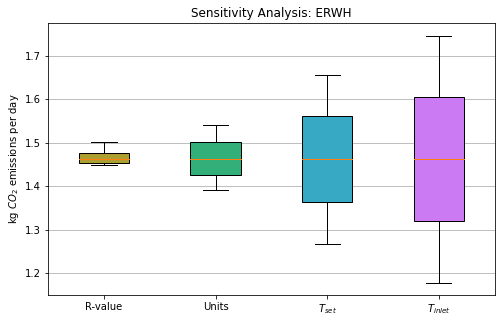

In [21]:
# Box plot:
data = [ere_R, ere_U, ere_T, ere_Tin]
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['R-value','Units','$T_{set}$','$T_{inlet}$']
bplot = ax.boxplot(data, vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax.set_title('Sensitivity Analysis: ERWH')
# fill with colors
colors = [pal.as_hex()[i] for i in range(1,5)]
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.yaxis.grid(True)
ax.set_ylabel('kg $CO_2$ emissions per day')
plt.savefig('../img/Sensitivity_analysisERWH.png',dpi = 200)

In [22]:
uncertainties = [R_uncertainty, Tset_uncertainty, Tin_uncertainty, U_uncertainty]

In [24]:
# Fractional Uncertainties:
fractional_uncertainty_R = R_uncertainty/(sum(uncertainties))
print('R fractional uncertainty (%):', fractional_uncertainty_R*100)
fractional_uncertainty_Tset = Tset_uncertainty/(sum(uncertainties))
print('T_set fractional uncertainty (%):',fractional_uncertainty_Tset*100)
fractional_uncertainty_Tin = Tin_uncertainty/(sum(uncertainties))
print('T_drop fractional uncertainty (%):',fractional_uncertainty_Tin*100)
fractional_uncertainty_users = U_uncertainty/(sum(uncertainties))
print('User fractional uncertainty (%):',fractional_uncertainty_users*100)

R fractional uncertainty (%): 4.666476403057481
T_set fractional uncertainty (%): 33.56522702572704
T_drop fractional uncertainty (%): 48.87117526550357
User fractional uncertainty (%): 12.897121305711915
